In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Importing Data

In [2]:
def load_data(filename):
    df = pd.read_csv(filename)
    df['start_time'] = pd.to_datetime(df['start_time'])
    df.set_index('start_time', inplace=True)
    return df

train_df = load_data('data/no1_train.csv')
val_df = load_data('data/no1_validation.csv')
train_altered_df = load_data('data/no1_train.csv')
val_altered_df = load_data('data/no1_validation.csv')

train_df.head()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


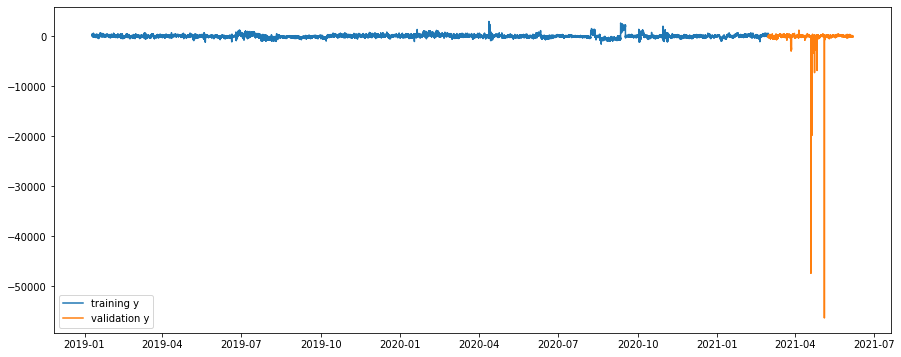

In [3]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(train_df['y'], label='training y')
plt.plot(val_df['y'], label='validation y')
plt.legend()

### Structural Imbalance

In [4]:
def calc_structural_imbalance(df, replace_y=False):
    sum = df['total'] + df['flow']
    interpolation = sum[df.index.minute == 30].resample('5min').interpolate(method='cubic')
    df['structural_imbalance'] = interpolation - sum

    if replace_y:
        df['y'] = df['y'] - df['structural_imbalance']

calc_structural_imbalance(train_df)
calc_structural_imbalance(val_df)
calc_structural_imbalance(train_altered_df, replace_y=True)
calc_structural_imbalance(val_altered_df, replace_y=True)

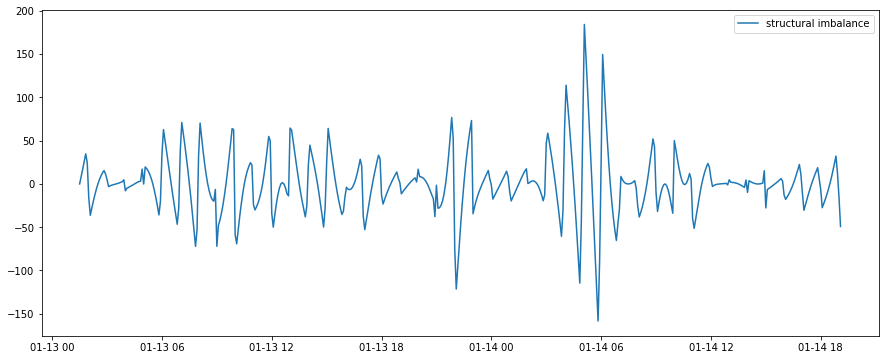

In [5]:
plt.plot(train_df['structural_imbalance'][1000:1500], label='structural imbalance')
plt.legend()

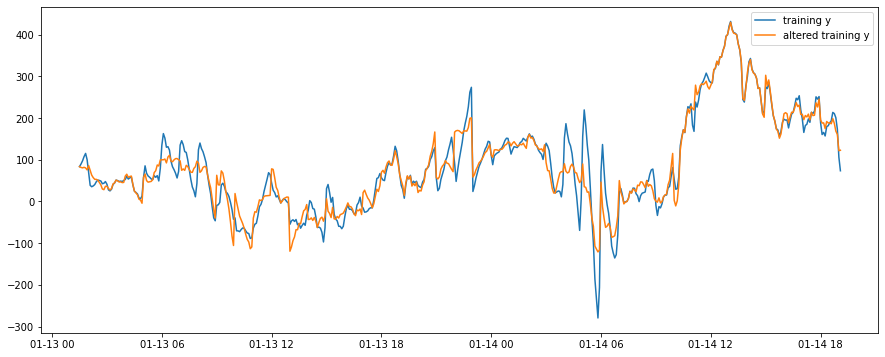

In [6]:
plt.plot(train_df['y'][1000:1500], label='training y')
plt.plot(train_altered_df['y'][1000:1500], label='altered training y')
plt.legend()

### Preprocessing

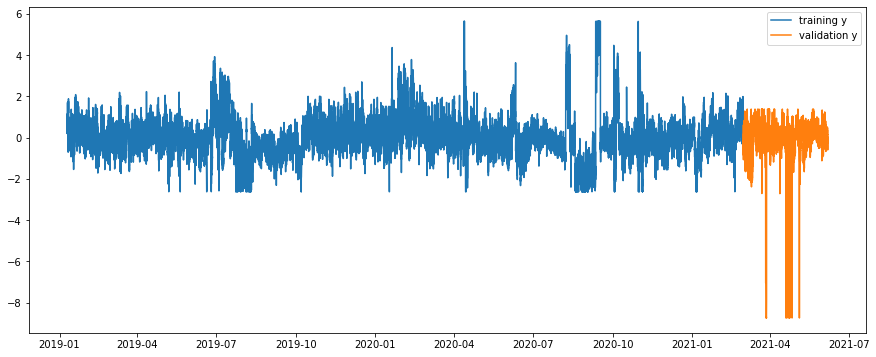

In [7]:
def preprocess(df):
    # Clip outliers
    df['y'] = df['y'].clip(upper=df['y'].quantile(0.995))
    df['y'] = df['y'].clip(lower=df['y'].quantile(0.005))
    # Normalize
    for col in df.columns:
        if df[col].std() != 0:
            df[col] = (df[col] - df[col].mean()) / df[col].std()

preprocess(train_df)
preprocess(val_df)
preprocess(train_altered_df)
preprocess(val_altered_df)

plt.plot(train_df['y'], label='training y')
plt.plot(val_df['y'], label='validation y')
plt.legend()

### Feature Engineering

In [8]:
def add_features(df):
    # Date time features
    df['time_of_day'] = (df.index.minute + df.index.hour * 60) / (24 * 60)
    df['time_of_week'] = (df['time_of_day'] + df.index.dayofweek) / 7
    df['time_of_year'] = (df['time_of_day'] + df.index.dayofyear) / 365
    # Lag features
    df['previous_y'] = df['y'].shift(1)
    df['previous_day_y'] = df['y'].shift(12 * 24)
    df['previous_day_mean_y'] = df['y'].rolling(12 * 24).mean()

add_features(train_df)
add_features(val_df)
add_features(train_altered_df)
add_features(val_altered_df)

In [9]:
train_df.head()

,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,structural_imbalance,time_of_day,time_of_week,time_of_year,previous_y,previous_day_y,previous_day_mean_y
start_time,,,,,,,,,,,,,,,,
2019-01-09 14:10:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.079339,0.417943,-1.843697,NaN,0.590278,0.370040,0.026275,NaN,NaN,NaN
2019-01-09 14:15:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.043030,0.417943,-1.843697,NaN,0.593750,0.370536,0.026284,1.079339,NaN,NaN
2019-01-09 14:20:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,1.022838,0.417943,-1.843697,NaN,0.597222,0.371032,0.026294,1.043030,NaN,NaN
2019-01-09 14:25:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,0.934010,0.417943,-1.843697,NaN,0.600694,0.371528,0.026303,1.022838,NaN,NaN
2019-01-09 14:30:00,-0.739389,-1.404748,-2.878692,0.39795,0.0,-0.833946,0.845497,0.417943,-1.843697,0.001516,0.604167,0.372024,0.026313,0.934010,NaN,NaN


### Dataset Generation

In [10]:
sequence_length = 12 * 12 # 12 hours

def create_dataset(df):
    return tf.keras.utils.timeseries_dataset_from_array(
        data=df,
        targets=df.iloc[sequence_length:][['y']],
        sequence_length=sequence_length,
        start_index=12 * 25,
        end_index=df.shape[0] - sequence_length - 12,
        sequence_stride=1,
        shuffle=True,
        batch_size=64
    )

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
train_altered_dataset = create_dataset(train_altered_df)
val_altered_dataset = create_dataset(val_altered_df)

train_dataset.element_spec

2022-05-05 13:10:41.483081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorSpec(shape=(None, None, 16), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))

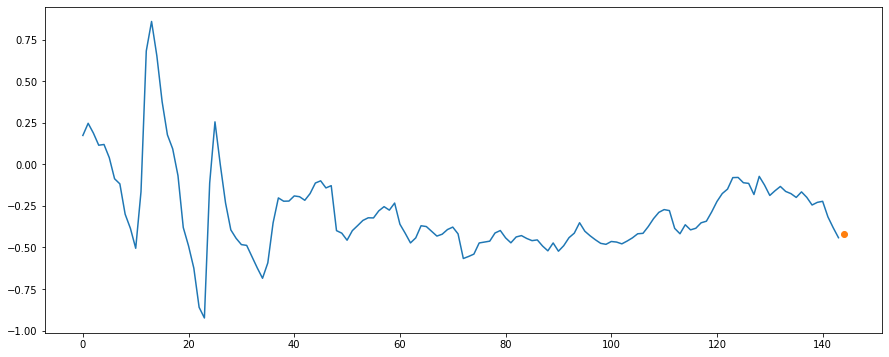

In [11]:
for x, y in train_dataset.take(1):
    plt.plot(x[0, :, 6])
    plt.plot(sequence_length, y[0], 'o')

### Normal Forecasting

#### Baseline Evaluation

In [12]:
class Baseline(tf.keras.Model):
  def call(self, inputs):
    return inputs[:, -1, 6]

baseline = Baseline()
baseline.compile(loss='mse')
print("Training dataset baseline loss:", baseline.evaluate(train_dataset))
print("Validation dataset baseline loss:", baseline.evaluate(val_dataset))

3508/3508 [==============================] - 33s 9ms/step - loss: 0.0156
Training dataset baseline loss: 0.015600568614900112
431/431 [==============================] - 4s 9ms/step - loss: 0.0523
Validation dataset baseline loss: 0.05227996036410332


#### Model

In [13]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(sequence_length, train_df.shape[1])),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(units=1)
])

lstm.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 74,369
Trainable params: 74,369
Non-trainable params: 0
_________________________________________________________________


#### Training

In [14]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='models/model.h5',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

try:
    lstm.load_weights('models/model.h5')
except FileNotFoundError:
    history = lstm.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=[es_callback, checkpoint_callback],
    )
    
    lstm.load_weights('models/model.h5')

    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()

#### Visualization

In [15]:
def forecast(model, df, start_ind, seq_len, forecast_len):
    df_copy = df.copy()
    for i in range(start_ind, start_ind + forecast_len):
        model_input = df_copy[i:i + seq_len].values.reshape((1, seq_len, df_copy.shape[1]))
        forecast = model.predict(model_input)
        df_copy['y'][i + seq_len] = forecast # replace y with forecast
        df_copy['previous_y'][i + seq_len + 1] = forecast # replace previous_y with forecast
        df_copy['previous_day_mean_y'] = df_copy['y'].rolling(12 * 24).mean() # update mean y with forecast
    return df_copy['y'][start_ind + seq_len:start_ind + seq_len + forecast_len]

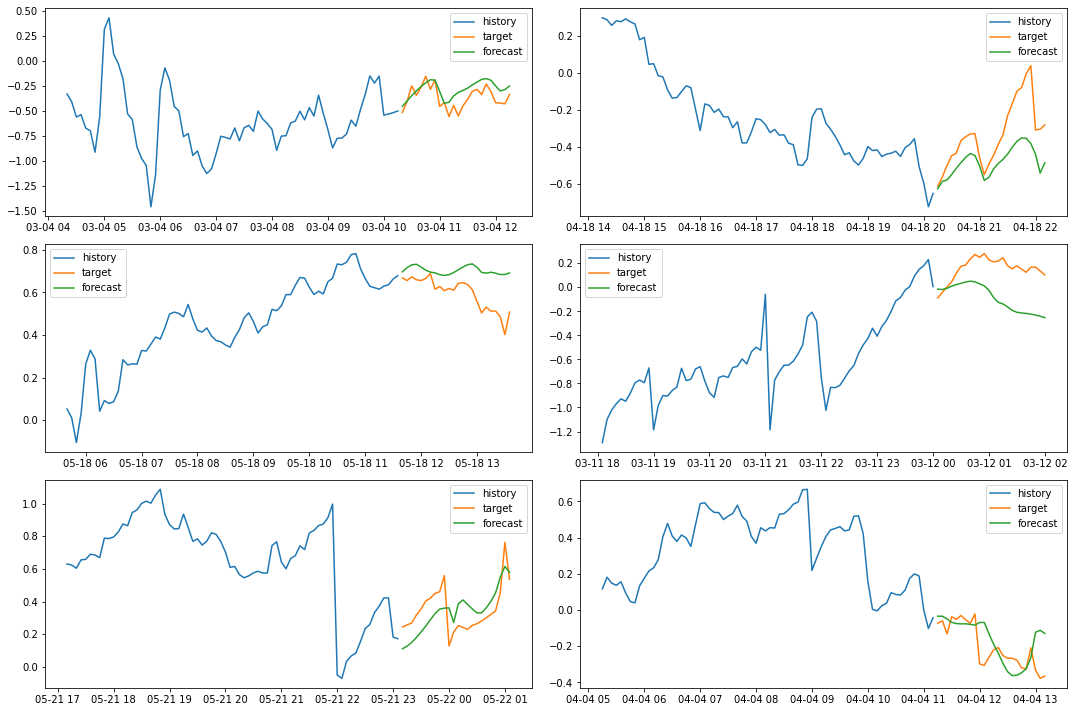

In [22]:
def plot_random_samples(model, df):
    hist_len = 12 * 12
    target_len = 12 * 2

    plt.rcParams['figure.figsize'] = (15, 10)
    f, axarr = plt.subplots(3, 2)
    for i in range(2):
        for j in range(3):
            start_ind = np.random.randint(df.shape[0] - hist_len - target_len - 12 * 24) + 12 * 24
            hist = df.iloc[start_ind:start_ind + hist_len]
            target = df.iloc[start_ind + hist_len:start_ind + hist_len + target_len]
            axarr[j][i].plot(hist['y'][12*6:], label='history')
            axarr[j][i].plot(target['y'], label='target')
            axarr[j][i].plot(forecast(model, df, start_ind, hist_len, target_len), label='forecast')
            axarr[j][i].legend()
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = (15, 6)

plot_random_samples(lstm, val_df)

### Altered Forecasting

#### Baseline Evaluation

In [17]:
print("Training dataset baseline loss:", baseline.evaluate(train_altered_dataset))
print("Validation dataset baseline loss:", baseline.evaluate(val_altered_dataset))

3508/3508 [==============================] - 25s 7ms/step - loss: 0.0150
Training dataset baseline loss: 0.01502910628914833
431/431 [==============================] - 4s 10ms/step - loss: 0.0533
Validation dataset baseline loss: 0.053315017372369766


#### Model

In [18]:
lstm_altered = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(sequence_length, train_altered_df.shape[1])),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(units=1)
])

lstm_altered.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse')
lstm_altered.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               74240     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,369
Trainable params: 74,369
Non-trainable params: 0
_________________________________________________________________


#### Training

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='models/model_altered.h5',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

try:
    lstm_altered.load_weights('models/model_altered.h5')
except FileNotFoundError:
    history = lstm_altered.fit(
        train_altered_dataset,
        epochs=20,
        validation_data=val_altered_dataset,
        callbacks=[es_callback, checkpoint_callback],
    )
    
    lstm_altered.load_weights('models/model_altered.h5')

    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()

#### Visualization

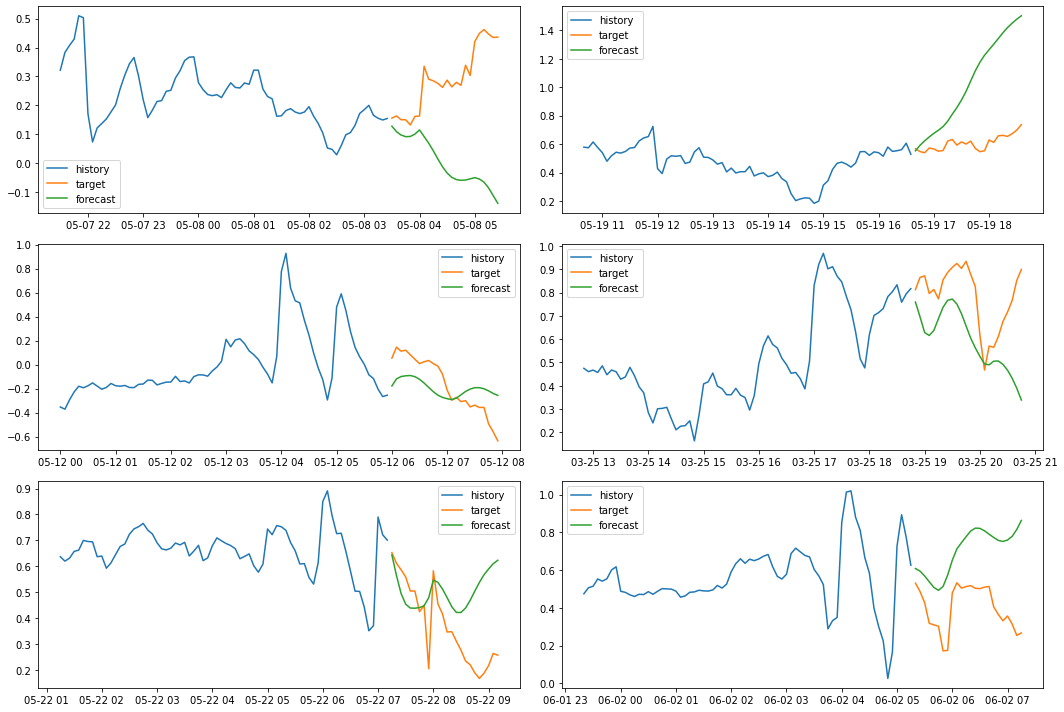

In [20]:
plot_random_samples(lstm_altered, val_df)

### Hold-out Evaluation

#### Normal Forecasting

In [ ]:
holdout_filename = 'data/HOLDOUT.csv'

holdout_df = load_data(holdout_filename)
calc_structural_imbalance(holdout_df)
preprocess(holdout_df)
add_features(holdout_df)
holdout_dataset = create_dataset(holdout_df)

plt.plot(holdout_df['y'])

In [ ]:
plot_random_samples(lstm, holdout_df)

#### Altered Forecasting

In [489]:
holdout_altered_df = load_data(holdout_filename)
calc_structural_imbalance(holdout_altered_df, replace_y=True)
preprocess(holdout_altered_df)
add_features(holdout_altered_df)
holdout_dataset = create_dataset(holdout_altered_df)

In [ ]:
plot_random_samples(lstm_altered, holdout_altered_df)